In [44]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from astropy.coordinates import SkyCoord
import astropy.units as u

import candel
from candel import SPEED_OF_LIGHT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def mean_sky_position(ra_deg, dec_deg):
    """
    Compute the mean sky position (RA, Dec) on the celestial sphere.
    """
    ra = np.deg2rad(ra_deg)
    dec = np.deg2rad(dec_deg)

    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    z_mean = np.mean(z)

    r = np.sqrt(x_mean**2 + y_mean**2 + z_mean**2)
    dec_mean = np.arcsin(z_mean / r)
    ra_mean = np.arctan2(y_mean, x_mean) % (2 * np.pi)

    return np.rad2deg(ra_mean), np.rad2deg(dec_mean)



def load_cepheid_table(filename):
    """Load Cepheid data from a LaTeX deluxetable."""
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("\\") or "colhead" in line:
                continue

            parts = [entry.strip().rstrip("\\") for entry in line.split("&")]

            if len(parts) != 11:
                continue

            try:
                row = (
                    str(parts[0]),
                    float(parts[1]),
                    float(parts[2]),
                    int(parts[3]),
                    float(parts[4]),
                    float(parts[5]),
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8]),
                    float(parts[9]),
                    str(parts[10])
                )
                data.append(row)
            except ValueError:
                continue  # skip malformed rows

    dtype = np.dtype([
        ("Field", "U10"),
        ("RA_J2000", "f8"),
        ("Dec_J2000", "f8"),
        ("Id", "i8"),
        ("P_days", "f8"),
        ("F555W_minus_F814W", "f8"),
        ("sigma_color", "f8"),
        ("F160W", "f8"),
        ("sigma_F160W", "f8"),
        ("OH", "f8"),
        ("Note", "U10")
    ])

    return np.array(data, dtype=dtype)


def compute_mean_galaxy_positions(arr):
    """
    Compute the mean sky position (RA, Dec) for each unique galaxy in a
    structured array.
    """
    galaxies = np.unique(arr["Field"])
    rows = []

    for name in galaxies:
        m = arr["Field"] == name
        ra = arr["RA_J2000"][m]
        dec = arr["Dec_J2000"][m]

        if len(ra) == 0:
            continue

        ra_mean, dec_mean = mean_sky_position(ra, dec)
        rows.append((name, ra_mean, dec_mean))

    dtype = np.dtype([
        ("Field", "U16"),
        ("RA_J2000", "f8"),
        ("Dec_J2000", "f8")
    ])

    return np.array(rows, dtype=dtype)


def crossmatch_galaxies_to_catalog(mean_pos_arr, ra_catalog, dec_catalog):
    """
    Cross-match galaxy positions to a catalog of sources.

    Parameters
    ----------
    mean_pos_arr : structured array
        Must contain "RA_J2000" and "Dec_J2000" fields (in degrees).
    ra_catalog : array_like
        RA values of catalog sources (in degrees).
    dec_catalog : array_like
        Dec values of catalog sources (in degrees).

    Returns
    -------
    idx : ndarray of int
        Indices into the catalog (ra_catalog/dec_catalog) corresponding to the
        closest match for each galaxy in mean_pos_arr.
    sep_arcsec : ndarray of float
        Angular separations to matched sources (in arcseconds).
    """
    gal_coords = SkyCoord(ra=mean_pos_arr["RA_J2000"] * u.deg,
                          dec=mean_pos_arr["Dec_J2000"] * u.deg)
    cat_coords = SkyCoord(ra=ra_catalog * u.deg, dec=dec_catalog * u.deg)

    idx, sep2d, _ = gal_coords.match_to_catalog_sky(cat_coords)
    return idx, sep2d.arcsec

In [46]:
# Load the SH0ES Cepheid table and Pantheon+ data
data_cepheid = load_cepheid_table("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/table2.tex")
data_pantheonplus = np.genfromtxt("/Users/rstiskalek/Projects/CANDEL/data/Pantheon+/Pantheon+SH0ES.dat", names=True, delimiter=" ", )
# data_pantheonplus = np.genfromtxt("/Users/rstiskalek/Projects/CANDEL/data/Pantheon+/Pantheon+SH0ES_zsel.dat", names=True, delimiter=" ", )

# Compute the sky position of the galaxies hosting Cepheids
galaxy_pos = compute_mean_galaxy_positions(data_cepheid)

# Crossmatch the anchors to the Pantheon+ catalog
ks, dtheta = crossmatch_galaxies_to_catalog(galaxy_pos, data_pantheonplus["RA"], data_pantheonplus["DEC"])


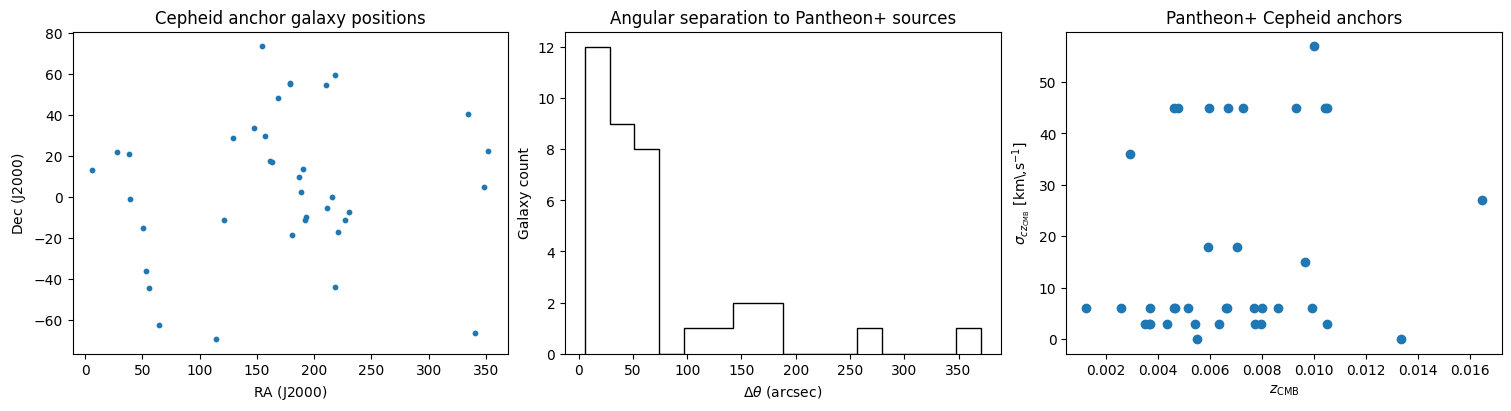

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# Panel 1: Galaxy positions
axes[0].set_title(r"Cepheid anchor galaxy positions")
axes[0].scatter(galaxy_pos["RA_J2000"], galaxy_pos["Dec_J2000"], s=10)
axes[0].set_xlabel(r"$\mathrm{RA}\ (\mathrm{J2000})$")
axes[0].set_ylabel(r"$\mathrm{Dec}\ (\mathrm{J2000})$")

# Panel 2: Angular separations
axes[1].hist(dtheta, bins="auto", histtype="step", color="k")
axes[1].set_xlabel(r"$\Delta \theta$ (arcsec)")
axes[1].set_ylabel(r"Galaxy count")
axes[1].set_title(r"Angular separation to Pantheon+ sources")

# Panel 3: Pantheon+ redshift uncertainties
axes[2].set_title(r"Pantheon+ Cepheid anchors")
axes[2].scatter(data_pantheonplus["zCMB"][ks],
                data_pantheonplus["zCMBERR"][ks] * SPEED_OF_LIGHT)
axes[2].set_xlabel(r"$z_{\rm CMB}$")
axes[2].set_ylabel(r"$\sigma_{cz_{\rm CMB}}$ [km\,s$^{-1}$]")

plt.show()

In [48]:
def match_qnames_to_pantheonplus(h5_path="/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_PantheonPlus_match.hdf5",
                                  shoes_data_path="/Users/rstiskalek/Projects/CANDEL/data/SH0ES"):
    """
    Match SH0ES q_names to all Pantheon+ fields available in the anchor file.
    
    Returns
    -------
    q_names : ndarray of str
    matched_data : dict of {field_name: ndarray}
        Each array is aligned with q_names; non-matched entries are NaN.
    """
    # Load SH0ES q_names
    data = candel.pvdata.load_SH0ES_separated(shoes_data_path)
    q_names = np.array(data["q_names"]).astype(str)

    # Base name extraction and manual patching
    gal_names_from_q = np.char.replace(q_names, "mu_", "")
    gal_names_from_q[gal_names_from_q == "N0105"] = "N105A"
    gal_names_from_q[gal_names_from_q == "N0976"] = "N976A"

    # Open HDF5 and extract data fields
    with File(h5_path, 'r') as f:
        galaxy_names = f["galaxy_pos/Field"][...].astype(str)
        pantheon_data = {k: f[f"pantheonplus/{k}"][...] for k in f["pantheonplus"]}

    # Perform matching
    common, i_q, i_gal = np.intersect1d(gal_names_from_q, galaxy_names, return_indices=True)

    # Prepare output dictionary
    matched_data = {}
    for key, arr in pantheon_data.items():
        if arr.dtype.kind in {"f", "i"}:
            arr_out = np.full(q_names.shape, np.nan)
            if key == "zCMBERR":
                arr = arr * SPEED_OF_LIGHT
            arr_out[i_q] = arr[i_gal]
            matched_data[key] = arr_out

    # Report unmatched
    unmatched = q_names[~np.isin(np.arange(len(q_names)), i_q)]
    if unmatched.size > 0:
        print("Still unmatched:")
        print(unmatched)

    return q_names, matched_data

In [80]:
q_names, matched_data = match_qnames_to_pantheonplus()

for key in list(matched_data.keys()):
    matched_data[key] = matched_data[key][:37]

q_names = q_names[:37]

assert np.isfinite(matched_data["zCMB"]).all()

2025-06-17 12:58:15 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-17 12:58:15 indices of zero width: [44]
2025-06-17 12:58:15 found zero-width prior at index 44. Setting it to 0.
Replacing2!
Still unmatched:
['Delta_mu_N4258' 'M_H1_W' 'Delta_mu_LMC' 'mu_M31' 'b_W' 'MB0' 'Z_W'
 'undefined' 'Delta_zp' 'log10_H0']


In [81]:
def matched_data_to_structured_array(q_names, matched_data):
    """
    Convert matched_data dict to a structured NumPy array aligned with q_names.
    """
    q_names = np.asarray(q_names).astype(str)
    names = np.char.replace(q_names, "mu_", "")

    dtype = [("Galaxy", "U16")] + [(k, "f8") for k in matched_data]
    arr = np.empty(len(q_names), dtype=dtype)
    arr["Galaxy"] = names

    for k in matched_data:
        arr[k] = matched_data[k]

    return arr


matched_data = matched_data_to_structured_array(q_names, matched_data)

In [82]:
x = np.genfromtxt("/Users/rstiskalek/Downloads/galaxy_snia_zHD.csv", delimiter=",", names=True)

In [83]:
for i in range(len(matched_data)):
    xi = matched_data[i]
    print(f"{xi['Galaxy']}, zHD = {xi['zHD']:.4f}, zCMB = {xi['zCMB']:.4f}, ")

M101, zHD = 0.0012, zCMB = 0.0012, 
M1337, zHD = 0.0092, zCMB = 0.0097, 
N0691, zHD = 0.0086, zCMB = 0.0086, 
N1015, zHD = 0.0081, zCMB = 0.0080, 
N0105, zHD = 0.0168, zCMB = 0.0165, 
N1309, zHD = 0.0072, zCMB = 0.0067, 
N1365, zHD = 0.0048, zCMB = 0.0046, 
N1448, zHD = 0.0038, zCMB = 0.0037, 
N1559, zHD = 0.0041, zCMB = 0.0043, 
N2442, zHD = 0.0049, zCMB = 0.0052, 
N2525, zHD = 0.0060, zCMB = 0.0060, 
N2608, zHD = 0.0086, zCMB = 0.0080, 
N3021, zHD = 0.0067, zCMB = 0.0059, 
N3147, zHD = 0.0108, zCMB = 0.0099, 
N3254, zHD = 0.0065, zCMB = 0.0055, 
N3370, zHD = 0.0059, zCMB = 0.0054, 
N3447, zHD = 0.0046, zCMB = 0.0046, 
N3583, zHD = 0.0086, zCMB = 0.0077, 
N3972, zHD = 0.0035, zCMB = 0.0037, 
N3982, zHD = 0.0035, zCMB = 0.0037, 
N4038, zHD = 0.0057, zCMB = 0.0066, 
N4424, zHD = 0.0026, zCMB = 0.0026, 
N4536, zHD = 0.0032, zCMB = 0.0035, 
N4639, zHD = 0.0036, zCMB = 0.0046, 
N4680, zHD = 0.0086, zCMB = 0.0093, 
N5468, zHD = 0.0095, zCMB = 0.0100, 
N5584, zHD = 0.0063, zCMB = 0.0063, 
N5

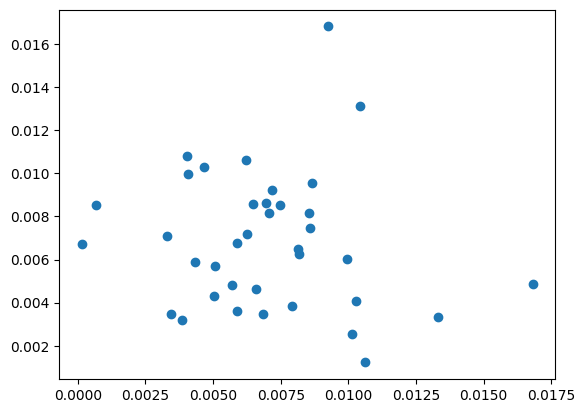

In [85]:
plt.figure()
plt.scatter(x["zHD"], matched_data["zHD"])


plt.show()



In [60]:
matched_data["zCMB"]

array([0.00122, 0.00966, 0.00861, 0.00801, 0.01646, 0.00668, 0.0046 ,
       0.00366, 0.00435, 0.00515, 0.00596, 0.00796, 0.00592, 0.00993,
       0.0055 , 0.0054 , 0.00465, 0.00773, 0.00369, 0.00369, 0.0066 ,
       0.00256, 0.0035 , 0.00462, 0.00931, 0.00998, 0.00635, 0.00478,
       0.0105 , 0.00727, 0.00703, 0.00293, 0.01042, 0.00769, 0.01049,
       0.01334, 0.00664])

In [51]:
matched_data

array([('M101', 29.177 , nan, -2.20084e-03, -4.43845e-04, -1.50198e-03,  54.2737,  88.3064, 8.12220e-01, -9., -999., 10.677  ,  0.000e+00, -999.,  56., 1., 29.0559, 1.51747 , 0.00758935, 101., 55815.2, 0.0579, 210.774 , 0.,  0.00000e+00, 250., 0.003, -0.0252, 0.004, 1., -0.032895, 0.038463,  9.78448, 0.0352442,  9.80286, 1.51723 , 0.0971, 1.496 , 2.1888   , 0.0710511 , -0.380481, 0.0861  , 0.00122,  5.99584916, 0.00122, 0.00084, 0.00082, 2.0e-05),
       ('M1337', 32.9183, nan, -4.29407e-05, -3.80399e-04,  9.88120e-06,  -9.7752,  70.3274, 5.33492e-03, -9., -999.,  9.554  ,  3.708e+00, -999.,  64., 1., 32.9159, 0.285505, 0.0393002 ,  43., 53757.4, 0.0782, 193.141 , 0.,  1.20873e+02, 250., 0.006,  0.0238, 0.009, 1., -0.026824, 0.027826, 13.8788 , 0.0396518, 13.6629 , 0.284225, 0.06  , 0.1981, 0.0504053, 0.00184083, -1.50889 , 0.050515, 0.00966, 14.9896229 , 0.00925, 0.00084, 0.00853, 5.0e-05),
       ('N0691', 32.8293, nan, -3.67614e-05, -2.70673e-05,  1.30680e-06,  21.7599, 144.299 , 7.

In [34]:
# filename_out = "/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_redshifts.npy"
# np.save(filename_out, matched_data)
print("Not saving!")


Not saving!


### Match supernovae from Pantheon+

In [35]:
!ls /Users/rstiskalek/Projects/CANDEL/data/Pantheon+/

Pantheon+SH0ES.dat
Pantheon+SH0ES_122221_VPEC.cov
Pantheon+SH0ES_STAT+SYS.cov
Pantheon+SH0ES_zsel.dat
Pantheon+SH0ES_zsel_STAT+SYS_noPV.cov
Pantheon+SH0ES_zsel_STAT+SYS_noPV_velspace.cov
los_CF4_Pantheon+_Carrick2015.hdf5


/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [36]:
matching

{}

In [37]:
data_pantheonplus["USED_IN_SH0ES_HF"].sum()

277.0

In [38]:
from os.path import join

data = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")


# Pantheon+ STATISTICAL & SYSTEMATIC covariance matrix
covmat = np.loadtxt(
    join("/Users/rstiskalek/Projects/CANDEL/data/Pantheon+/", "Pantheon+SH0ES_STAT+SYS.cov"), delimiter=",")
    # join("/Users/rstiskalek/Projects/CANDEL/data/Pantheon+/", "Pantheon+SH0ES_zsel_STAT+SYS_noPV.cov"), delimiter=",")
size = int(covmat[0])
C = np.reshape(covmat[1:], (size, size))


# Select calibrators, i.e. SNe in Cepheid host galaxies
m = data_pantheonplus["IS_CALIBRATOR"] == 1

from scipy.optimize import linear_sum_assignment

# Your input arrays
x = data_pantheonplus["RA"][m]
y = data["L_SN_Cepheid_dist"] @ np.hstack([data["RA_host"], [0, 0, 0]])
cost1 = (x[:, None] - y[None, :])

x = data_pantheonplus["m_b_corr"][m]
y = data["Y_SN_Cepheid"]
cost2 = (x[:, None] - y[None, :])**2

cost = cost1 / np.mean(cost1) + cost2 / np.mean(cost2)

row_ind, col_ind = linear_sum_assignment(cost)
matching = dict(zip(col_ind, row_ind))
ordering = np.asarray([matching[i] for i in range(len(y))])

# Calibrator indices
k_calibrator = np.arange(len(C))[m][ordering]

m = data_pantheonplus["USED_IN_SH0ES_HF"] == 1

k_HF = np.arange(len(C))[m]

ks = np.hstack([k_calibrator, k_HF])
data_pp_matched = data_pantheonplus[ks]
C_pp_matched = C[ks][:, ks]


2025-06-17 08:01:28 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-17 08:01:28 indices of zero width: [44]
2025-06-17 08:01:28 found zero-width prior at index 44. Setting it to 0.
Replacing2!


In [39]:
filename_out = "/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/PP_SN_matched_to_SH0ES.npz"
np.savez(filename_out, pp_matched=data_pp_matched, cov=C_pp_matched)

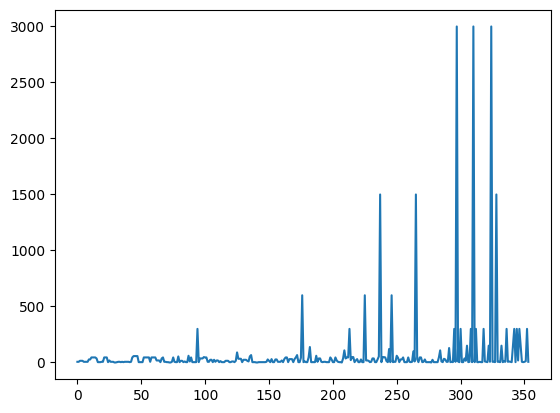

In [40]:
plt.figure()
plt.plot(data_pp_matched["zCMBERR"]* SPEED_OF_LIGHT)
plt.show()

In [41]:
x = np.abs(data["C_SN"] - C_pp_matched)

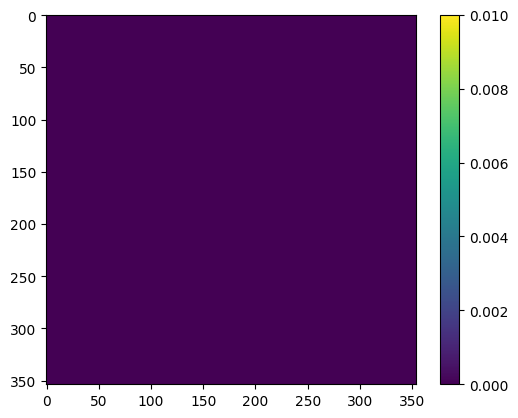

In [42]:
plt.figure()
plt.imshow(x, cmap="viridis", vmax=0.01)

plt.colorbar()
plt.show()

In [43]:
x = np.hstack([data["RA_host"], [0, 0, 0]])

plt.figure()
# plt.scatter(data_pp_sorted["RA"], data["L_SN_Cepheid_dist"] @ x)
plt.scatter(data_pp_calibrators["m_b_corr"], data["Y_SN_Cepheid"] - data_pp_sorted["m_b_corr"])
plt.show()

NameError: name 'data_pp_calibrators' is not defined

<Figure size 640x480 with 0 Axes>

(0.007852795191761285, 0.055400038146972364)